![enter image description here](https://img.shields.io/badge/Author-Nestor_Batista_Díaz-yellow)

# <center>Actividad 3.5</br>Clasificación de vinos</center>

## IMPORTS

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import  StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import  train_test_split, RandomizedSearchCV
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

import joblib

## RED WINES 

### DATASET

In [395]:
df = pd.read_csv("https://raw.githubusercontent.com/Nestorbd/Clasificacion-de-vinos/master/wine%2Bquality/winequality-red.csv", sep=";")
df.shape

(1599, 12)

In [396]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [397]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### NORMALIZACIÓN

In [398]:
column_names = df.columns.values
index_to_remove = np.where(column_names == 'quality')[0]
column_names = np.delete(column_names, index_to_remove)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('quality', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

### SELECCIÓN DE CARACTERISTICAS 

#### MATRIZ DE CORRELACIÓN

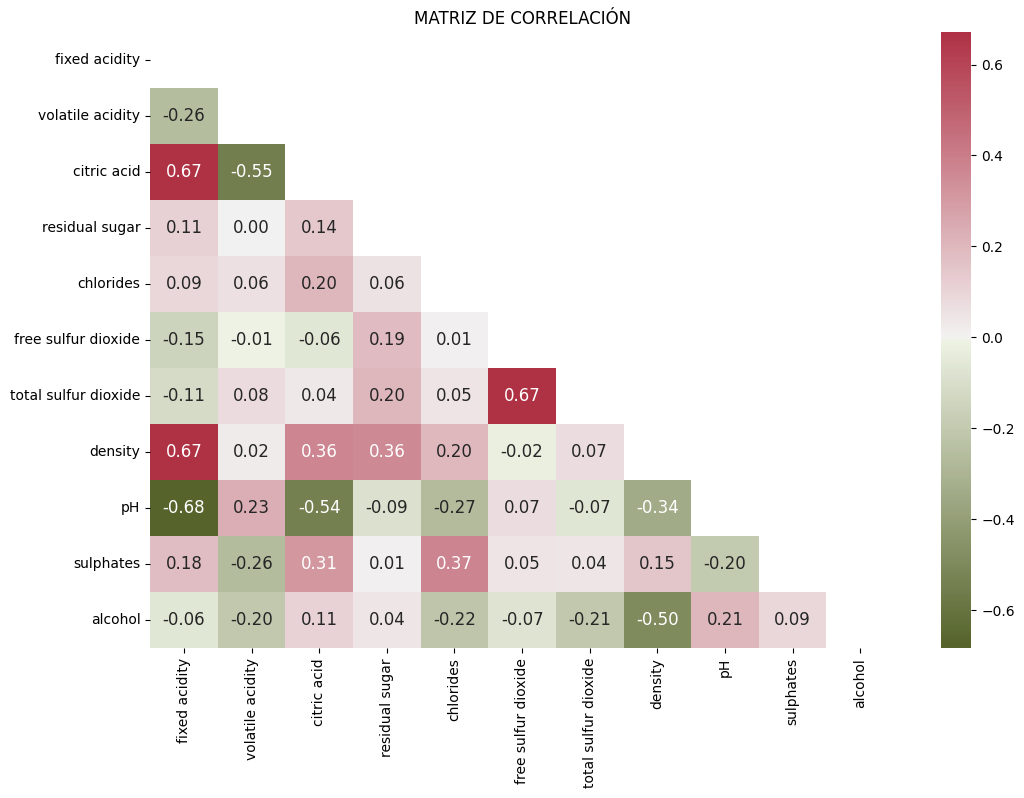

In [399]:
corr_mat_data = scaled_df.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('MATRIZ DE CORRELACIÓN');

#### SelectKBest

In [400]:
X = scaled_df
y = df['quality']

columns_name = df.columns.tolist()

# Crear el objeto SelectKBest con f_classif como función de puntuación
selector = SelectKBest(f_classif, k=8)  # Por ejemplo, seleccionamos las 8 mejores características

# Aplicar la transformación a tus datos
X_new = selector.fit_transform(X, y)

# Obtener las características seleccionadas
selected_features = selector.get_support(indices=True)
selected_features_names = [columns_name[i] for i in selected_features]

# Imprimir las características seleccionadas
print("Características seleccionadas:", selected_features_names)


Características seleccionadas: ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol']


### COMPARACIÓN DE MODELOS

In [401]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_names], y, test_size=0.2, random_state=42)

#### BAGGING (BaggingClassifier)

In [402]:
# Crear un clasificador base
base_classifier = DecisionTreeClassifier()

# Crear el clasificador Bagging
bagging = BaggingClassifier(base_classifier)

# Definir los parámetros que deseas ajustar
param_dist = {
    'n_estimators': randint(10, 100),
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_bagging = RandomizedSearchCV(bagging, param_distributions=param_dist, n_iter=10)

# Ajustar el modelo
random_search_bagging.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search_bagging.best_params_)
print("Accuracy: ", random_search_bagging.best_score_)

Mejores parámetros encontrados: {'max_features': 0.9, 'max_samples': 0.7, 'n_estimators': 71}
Accuracy:  0.6841574754901961


In [403]:
# Obtener predicciones del modelo en el conjunto de prueba
y_pred_bagging = random_search_bagging.predict(X_test)

In [404]:
# Calcular la matriz de confusión
cm_bagging = confusion_matrix(y_test, y_pred_bagging)

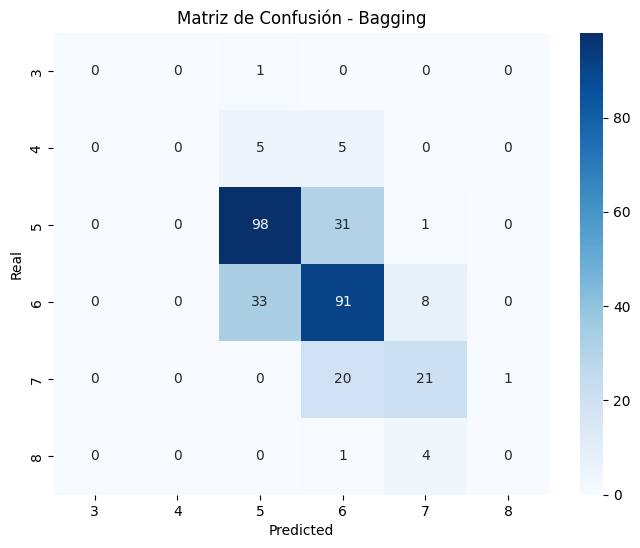

In [405]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Bagging')
plt.show()

#### RANDOM FOREST (RandomForestClassifier)

In [406]:
# Crear el clasificador RandomForest
random_forest = RandomForestClassifier()

# Definir los parámetros que deseas ajustar
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_random_forest = RandomizedSearchCV(random_forest, param_distributions=param_dist, n_iter=10, error_score='raise')

# Ajustar el modelo
random_search_random_forest.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search_random_forest.best_params_)
print("Accuracy: ", random_search_random_forest.best_score_)

Mejores parámetros encontrados: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 703}
Accuracy:  0.6747732843137255


In [407]:
# Obtener predicciones del modelo en el conjunto de prueba
y_pred_random_forest = random_search_random_forest.predict(X_test)

In [408]:
# Calcular la matriz de confusión
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)

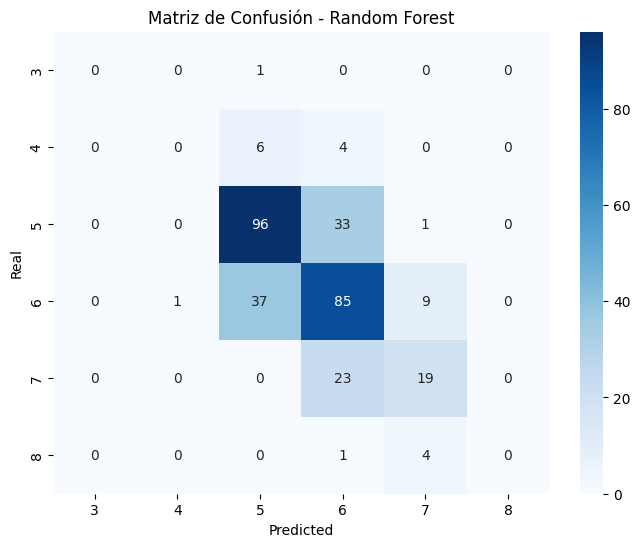

In [409]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_random_forest, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

#### BOOSTED TREES (AdaBoostClassifier)

In [410]:
# Crear el clasificador AdaBoost con el algoritmo SAMME
adaboost = AdaBoostClassifier(algorithm='SAMME')

# Definir los parámetros que deseas ajustar
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_adaboost = RandomizedSearchCV(adaboost, param_distributions=param_dist, n_iter=10)

# Ajustar el modelo
random_search_adaboost.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search_adaboost.best_params_)
print("Accuracy: ", random_search_adaboost.best_score_)

Mejores parámetros encontrados: {'learning_rate': 0.1, 'n_estimators': 125}
Accuracy:  0.5786305147058823


In [411]:
# Obtener predicciones del modelo en el conjunto de prueba
y_pred_adaboost = random_search_adaboost.predict(X_test)

In [412]:
# Calcular la matriz de confusión
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)

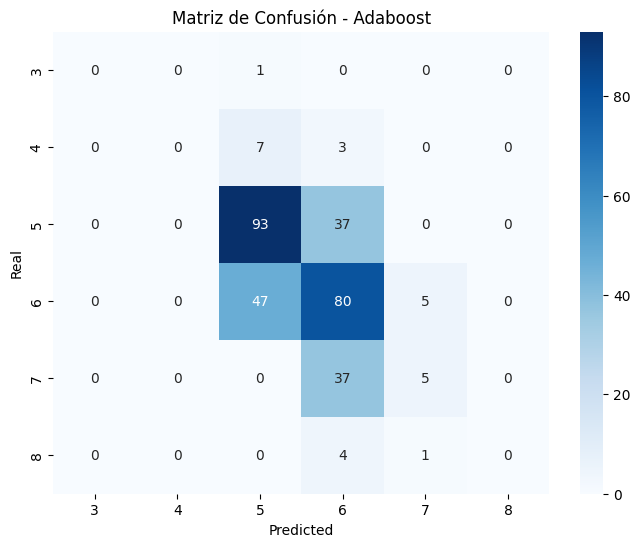

In [413]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adaboost, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Adaboost')
plt.show()

### EXPORTAR MODELO (BaggingClassifier)

In [414]:
# Exportar el modelo a un fichero
joblib.dump(random_search_bagging,'wine_red_quality_bagging_modelo_entrenado.pkl')

['wine_red_quality_bagging_modelo_entrenado.pkl']

### IMPORTAR MODELO (BaggingClassifier)

In [415]:
modelo_bagging_entrenado = joblib.load('wine_red_quality_bagging_modelo_entrenado.pkl')
modelo_bagging_entrenado.score(X[selected_features_names], y)

0.9280800500312696

#### PREDECIR CON TODOS LOS DATOS

In [416]:
y_pred_modelo_bagging_entrenado = modelo_bagging_entrenado.predict(X[selected_features_names])

In [417]:
# Calcular la matriz de confusión
cm_modelo_bagging_entrenado = confusion_matrix(y, y_pred_modelo_bagging_entrenado)

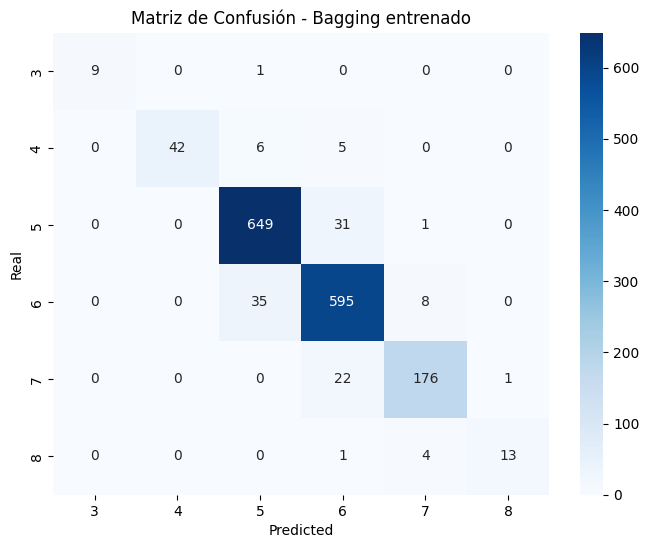

In [418]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_modelo_bagging_entrenado, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Bagging entrenado')
plt.show()

In [419]:
# Calcular la precisión de las predicciones
accuracy = accuracy_score(y, y_pred_modelo_bagging_entrenado)

print("Precisión del modelo de Bagging:", accuracy)

Precisión del modelo de Bagging: 0.9280800500312696


## WHITE WINES

### DATASET

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/Nestorbd/Clasificacion-de-vinos/master/wine%2Bquality/winequality-white.csv", sep=";")
df.shape

(4898, 12)

In [421]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [422]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


### NORMALIZACIÓN

In [423]:
column_names = df.columns.values
index_to_remove = np.where(column_names == 'quality')[0]
column_names = np.delete(column_names, index_to_remove)

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df.drop('quality', axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=column_names)

### SELECCIÓN DE CARACTERISTICAS 

#### MATRIZ DE CORRELACIÓN

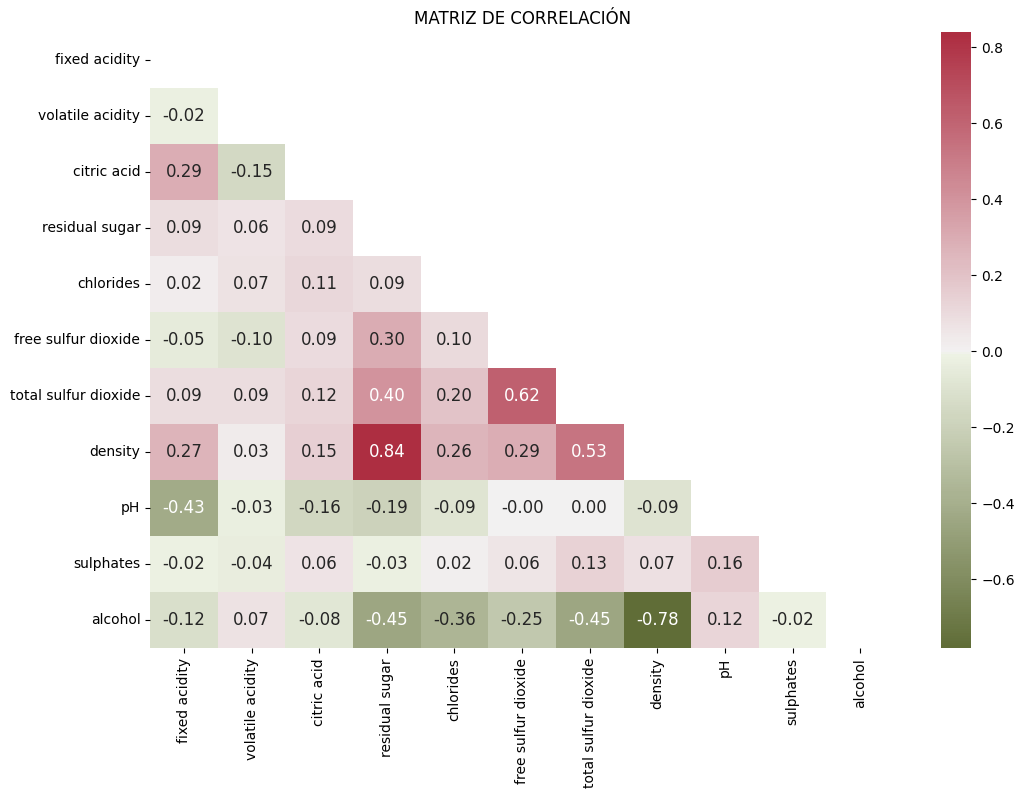

In [424]:
corr_mat_data = scaled_df.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype = bool))

cmap = sns.diverging_palette(100, 7, s = 75, l = 40, n = 5, center = 'light', as_cmap = True)

plt.figure(figsize = (12, 8))
sns.heatmap(corr_mat_data, annot = True, cmap = cmap, fmt = '.2f', center = 0,
            annot_kws = {'size': 12}, mask = data_mask).set_title('MATRIZ DE CORRELACIÓN');

#### SelectKBest

In [425]:
X = scaled_df
y = df['quality']

columns_name = df.columns.tolist()

# Crear el objeto SelectKBest con f_classif como función de puntuación
selector = SelectKBest(f_classif, k=8)  # Por ejemplo, seleccionamos las 8 mejores características

# Aplicar la transformación a tus datos
X_new = selector.fit_transform(X, y)

# Obtener las características seleccionadas
selected_features = selector.get_support(indices=True)
selected_features_names = [columns_name[i] for i in selected_features]

# Imprimir las características seleccionadas
print("Características seleccionadas:", selected_features_names)


Características seleccionadas: ['fixed acidity', 'volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'alcohol']


### COMPARACIÓN DE MODELOS

In [426]:
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_names], y, test_size=0.2, random_state=42)

#### BAGGING (BaggingClassifier)

In [427]:
# Crear un clasificador base
base_classifier = DecisionTreeClassifier()

# Crear el clasificador Bagging
bagging = BaggingClassifier(base_classifier)

# Definir los parámetros que deseas ajustar
param_dist = {
    'n_estimators': randint(10, 100),
    'max_samples': [0.5, 0.7, 0.9, 1.0],
    'max_features': [0.5, 0.7, 0.9, 1.0]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_bagging = RandomizedSearchCV(bagging, param_distributions=param_dist, n_iter=10)

# Ajustar el modelo
random_search_bagging.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search_bagging.best_params_)
print("Accuracy: ", random_search_bagging.best_score_)

Mejores parámetros encontrados: {'max_features': 0.5, 'max_samples': 0.9, 'n_estimators': 46}
Accuracy:  0.6510956681523183


In [428]:
# Obtener predicciones del modelo en el conjunto de prueba
y_pred_bagging = random_search_bagging.predict(X_test)

In [429]:
# Calcular la matriz de confusión
cm_bagging = confusion_matrix(y_test, y_pred_bagging)

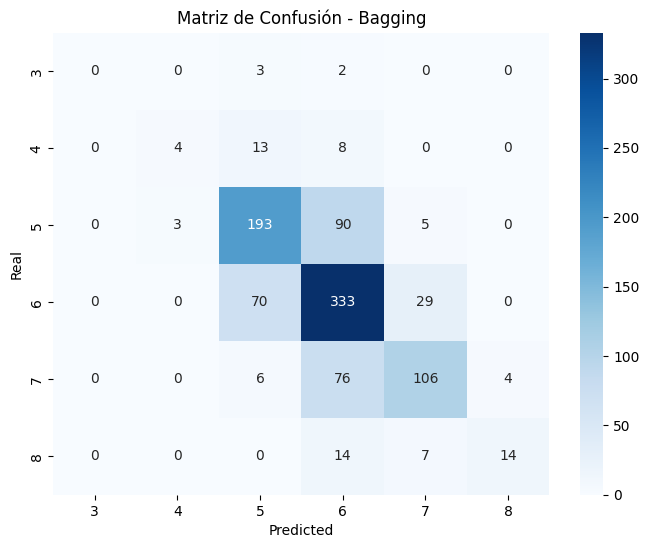

In [430]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bagging, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Bagging')
plt.show()

#### RANDOM FOREST (RandomForestClassifier)

In [431]:
# Crear el clasificador RandomForest
random_forest = RandomForestClassifier()

# Definir los parámetros que deseas ajustar
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_random_forest = RandomizedSearchCV(random_forest, param_distributions=param_dist, n_iter=10, error_score='raise')

# Ajustar el modelo
random_search_random_forest.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search_random_forest.best_params_)
print("Accuracy: ", random_search_random_forest.best_score_)

Mejores parámetros encontrados: {'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 982}
Accuracy:  0.6475190267677953


In [432]:
# Obtener predicciones del modelo en el conjunto de prueba
y_pred_random_forest = random_search_random_forest.predict(X_test)

In [433]:
# Calcular la matriz de confusión
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)

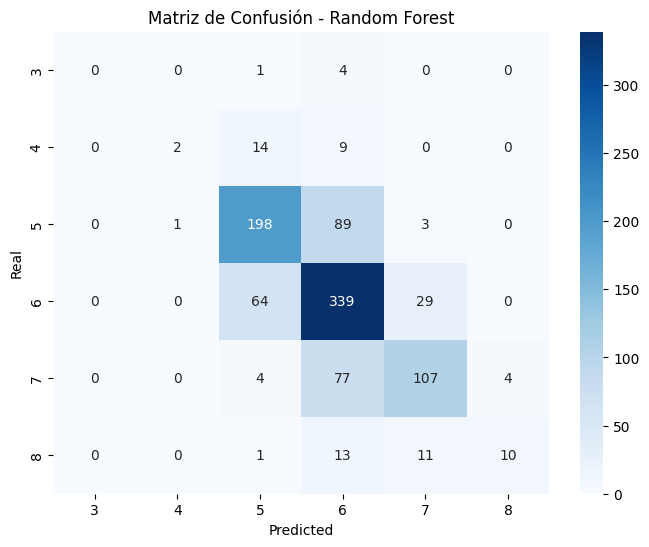

In [434]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_random_forest, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Random Forest')
plt.show()

#### Boosted Trees (AdaBoostClassifier)

In [435]:
# Crear el clasificador AdaBoost con el algoritmo SAMME
adaboost = AdaBoostClassifier(algorithm='SAMME')

# Definir los parámetros que deseas ajustar
param_dist = {
    'n_estimators': randint(50, 500),
    'learning_rate': [0.01, 0.1, 1.0, 10.0]
}

# Realizar la búsqueda aleatoria de hiperparámetros
random_search_adaboost = RandomizedSearchCV(adaboost, param_distributions=param_dist, n_iter=10)

# Ajustar el modelo
random_search_adaboost.fit(X_train, y_train)

# Mostrar los mejores parámetros encontrados
print("Mejores parámetros encontrados:", random_search_adaboost.best_params_)
print("Accuracy: ", random_search_adaboost.best_score_)

Mejores parámetros encontrados: {'learning_rate': 0.01, 'n_estimators': 428}
Accuracy:  0.51530807725389


In [436]:
# Obtener predicciones del modelo en el conjunto de prueba
y_pred_adaboost = random_search_adaboost.predict(X_test)

In [437]:
# Calcular la matriz de confusión
cm_adaboost = confusion_matrix(y_test, y_pred_adaboost)

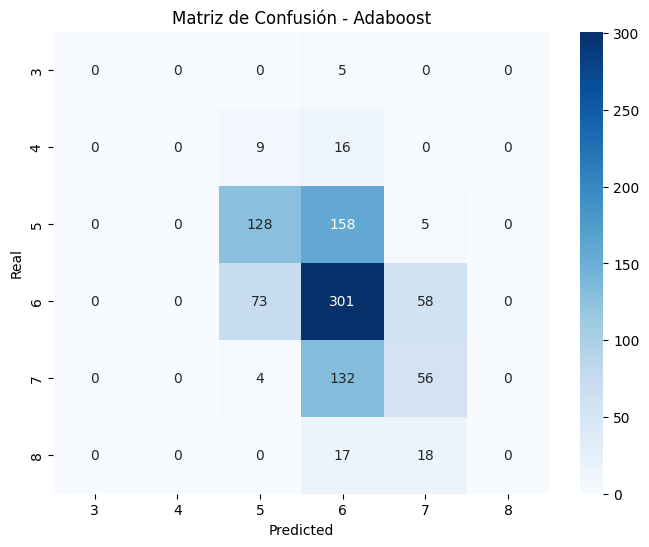

In [438]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adaboost, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Adaboost')
plt.show()

### EXPORTAR MODELO (BaggingClassifier)

In [439]:
# Exportar el modelo a un fichero
joblib.dump(random_search_bagging,'wine_white_quality_bagging_modelo_entrenado.pkl')

['wine_white_quality_bagging_modelo_entrenado.pkl']

### IMPORTAR MODELO (BaggingClassifier)

In [440]:
modelo_bagging_entrenado = joblib.load('wine_white_quality_bagging_modelo_entrenado.pkl')
modelo_bagging_entrenado.score(X[selected_features_names], y)

0.9326255614536546

#### PREDECIR CON TODOS LOS DATOS

In [441]:
y_pred_modelo_bagging_entrenado = modelo_bagging_entrenado.predict(X[selected_features_names])

In [442]:
# Calcular la matriz de confusión
cm_modelo_bagging_entrenado = confusion_matrix(y, y_pred_modelo_bagging_entrenado)

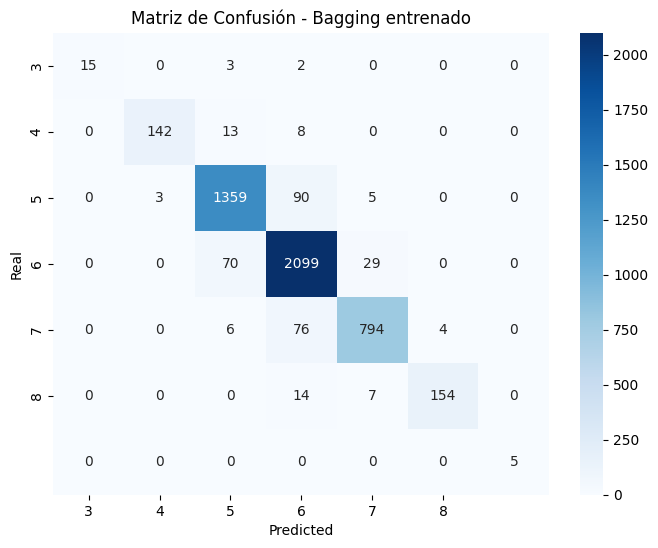

In [443]:
# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm_modelo_bagging_entrenado, annot=True, fmt='d', cmap='Blues', xticklabels=[3,4,5,6,7,8], yticklabels=[3,4,5,6,7,8],)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Matriz de Confusión - Bagging entrenado')
plt.show()

In [444]:
# Calcular la precisión de las predicciones
accuracy = accuracy_score(y, y_pred_modelo_bagging_entrenado)

print("Precisión del modelo de Bagging:", accuracy)

Precisión del modelo de Bagging: 0.9326255614536546
